<a href="https://colab.research.google.com/github/weathon/slay/blob/main/Metric_Verificatio_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import pylab
import numpy as np

In [72]:
import numpy as np
import pandas as pd 
import random
import pylab 
import multiprocessing
import time
from pyrsistent import l
import timeit

def ifNone(a):
    if type(a) == type(None):
        return True
    else:
        return False

def maxPerArg(list1, list2):
    if len(list1) != len(list2):
        raise Exception("OOBA %s,%s" % (len(list1), len(list2)))
    ans = list1[:]
    for i in range(len(list1)):
        if list2[i]>list1[i]:
            ans[i] = list2[i]
    return ans

def minPerArg(list1, list2):
    if len(list1) != len(list2):
        raise Exception("OOBA %s,%s" % (len(list1), len(list2)))
    ans = list1[:]
    for i in range(len(list1)):
        if list2[i]<list1[i]:
            ans[i] = list2[i]
    return ans

class dataPoint:
    def __init__(self, d, id):
        self.data = d
        self.id = id
        self.ancestorsDistances = {}
        self.ancestorsDistancesList = []
        self.distanceFromDad = -1
        self.max = -1
        self.min = -1
        self.fars = [-1]
        self.nears = [-1]
    def __str__(self):
        return str(self.data)

def randomArray():
    size = 100
    ans = []
    for i in range(size):
        ans.append(random.choice([0,1]))
    return np.array(ans)



class BallTreeNode:
  def __init__(self):
    self.myobject = None
    self.inner = None
    self.outer = None
    self.left = None
    self.right = None
    self.count = 0

def getData(myArray):
    myArray.sort(key=lambda x: x.distanceFromDad)
    theMax = myArray[-1].distanceFromDad
    theMin = myArray[0].distanceFromDad
    inner = myArray[int(len(myArray)/2)-1].distanceFromDad
    outer = myArray[int(len(myArray)/2)].distanceFromDad
    return theMax, theMin, inner, outer, myArray


counts = 0
def d(a, b, r=0):
  global counts
  a, b = a.data, b.data
  counts+=1
  dis = 0
  for i in range(len(a)):
    if a[i]!=b[i]:
      dis+=1
  return dis


def ConstructBallTree(BT, localobjects):
  if len(localobjects)==0:
    return BT
  if len(localobjects)==1:
    BT.myobject = localobjects[0]
    BT.inner = 0
    BT.outer = 0
    BT.count = 1
    return BT
  selectedIndex = random.randint(0,len(localobjects)-1)
  localobjects[-1], localobjects[selectedIndex] = localobjects[selectedIndex], localobjects[-1] 
  BT.myobject = localobjects[-1]
  localobjects = localobjects[:-1]
  
  
  for i in range(len(localobjects)):
    localobjects[i].distanceFromDad=d(BT.myobject, localobjects[i])
    localobjects[i].ancestorsDistancesList.append(localobjects[i].distanceFromDad)
  
  BT.myobject.max, BT.myobject.min, BT.inner, BT.outer, sortedlocalobjects = getData(localobjects)

  
  

  L = []
  R = []
  for i in range(len(localobjects)):
    if localobjects[i].distanceFromDad<=BT.inner:
      L.append(localobjects[i])
    elif localobjects[i].distanceFromDad>=BT.outer:
      R.append(localobjects[i])
    else:
      print("where am i", BT.inner,BT.outer)

  BT.count = len(localobjects)

  if len(L) != 0:
    BT.left = ConstructBallTree(BallTreeNode(),L)
  if len(R) != 0:
    BT.right = ConstructBallTree(BallTreeNode(),R)
  
  

  return BT


def generateCMTData(BT):
    if ifNone(BT):
        return [], []
    Lnear, Lfar = generateCMTData(BT.left)
    Rnear, Rfar = generateCMTData(BT.right)
    Lnear, Lfar, Rnear, Rfar = Lnear[:-1], Lfar[:-1], Rnear[:-1], Rfar[:-1]
    
    if len(Lnear) != 0 and len(Rnear) != 0:
        
        BT.myobject.nears = minPerArg(minPerArg(Lnear, Rnear), BT.myobject.ancestorsDistancesList)
        BT.myobject.fars = maxPerArg(maxPerArg(Lfar, Rfar), BT.myobject.ancestorsDistancesList)
    elif len(Lnear) != 0:
        
        BT.myobject.nears = minPerArg(Lnear, BT.myobject.ancestorsDistancesList)
        BT.myobject.fars = maxPerArg(Lfar, BT.myobject.ancestorsDistancesList)
    elif len(Rnear) != 0:
        
        BT.myobject.nears = minPerArg(Rnear, BT.myobject.ancestorsDistancesList)
        BT.myobject.fars = maxPerArg(Rfar, BT.myobject.ancestorsDistancesList)
    elif len(Rnear) == 0 and len(Lnear) == 0:
    
        
        BT.myobject.nears = BT.myobject.ancestorsDistancesList
        BT.myobject.fars = BT.myobject.ancestorsDistancesList 
        
        
        
    
    
    returnNear = BT.myobject.nears
    returnFar = BT.myobject.fars

    return returnNear, returnFar
    



def maxPD(stack, node): 
    nears = node.myobject.nears
    fars = node.myobject.fars
    if len(stack) != len(fars):
        
        raise Exception("stack and fars not match %s, %s" %(len(stack), len(fars)))
    maxPDV = 0
    for i in range(len(stack)):
        
        if fars[i] < stack[i]:
            
            maxPDV = max(maxPDV, stack[i] - fars[i]) 
        elif nears[i] > stack[i]:
            maxPDV = max(maxPDV, nears[i] - stack[i])
    # print(maxPDV)
    return maxPDV
        

def CMTSearchRadius(BT, Object, r, ans):
  global stack
  if BT == None:
    return

  maxPDV = maxPD(stack, BT) 
      
  if maxPDV > r:
    return
    
  dis = d(Object, BT.myobject, r)
    
  if dis <= r:
    ans.append(BT.myobject)  

  # if type(BT.myobject.max) != type(None):
  #   if dis > BT.myobject.max:
  #     if dis - BT.myobject.max > r: 
  #       return

  # if type(BT.myobject.min) != type(None):
  #   if dis < BT.myobject.min:
  #     if BT.myobject.min - dis > r:
  #       return  
  
  stack.append(dis)
  if dis + r >= BT.outer:
    CMTSearchRadius(BT.right, Object, r, ans)
  if BT.inner >= dis - r:                              
    CMTSearchRadius(BT.left, Object, r, ans)
  stack.pop()

In [73]:
def searchBF(objects, target, r):
  ans = []
  for i in objects:
    if d(target, i)<=r:
      ans.append(i)
  return ans

In [74]:
def BaselineSearchRadius(BT, Object, r, ans):
  if BT == None:
    return
  dis = d(Object, BT.myobject, r)
  if dis <= r:
    ans.append(BT.myobject)
  

  if type(BT.myobject.max) != type(None):
    if dis > BT.myobject.max:
      if dis - BT.myobject.max > r: 
        return

  if type(BT.myobject.min) != type(None):
    if dis < BT.myobject.min:
      if BT.myobject.min - dis > r:
        return  
  
  
  
  if dis + r >= BT.outer:
    BaselineSearchRadius(BT.right, Object, r, ans)
  if BT.inner >= dis - r:                              
    BaselineSearchRadius(BT.left, Object, r, ans)


In [75]:
def ver(a, b, Rs):
  global counts
  if_act_is_greater_than_thershold = np.array([0] * 7)
  if_act_is_greater_than_or_equal_to_thershold = np.array([0] * 7)
  a, b = a.data, b.data
  counts+=1
  dis = 0
  for i in range(len(a)):
    if a[i]!=b[i]:
      dis+=1
      for j in range(7):
        if dis>=Rs[j]:
          if_act_is_greater_than_or_equal_to_thershold[j]= 1

        if dis>Rs[j]:
          if_act_is_greater_than_thershold[j] = 1

      # if np.all(if_act_is_greater_than_or_equal_to_thershold):
      #   # print("Exit early") #yachiyansaunduzi siyuhuyicimeichufa
      #   # print(if_act_is_greater_than_or_equal_to_thershold)
      #   return if_act_is_greater_than_thershold, if_act_is_greater_than_or_equal_to_thershold #without this it worked order
  return if_act_is_greater_than_thershold, if_act_is_greater_than_or_equal_to_thershold
    

In [76]:
def VerSearchRadius(BT, Object, r, ans):
  if BT == None:
    return
  # dis = d(Object, BT.myobject, r)
  sgt, sge = ver(Object, BT.myobject, [r, BT.myobject.max, r + BT.myobject.max, BT.myobject.min, BT.myobject.min-r, BT.outer - r, BT.inner + r])
  if BT == None:
    return
  # dis = d(Object, BT.myobject, r) 
  # if dis <= r:
  if not sgt[0]:
    ans.append(BT.myobject)
  

  # if type(BT.myobject.max) != type(None):
  #   # if dis > BT.myobject.max:
  #   if sgt[1]:
  #     # if dis - BT.myobject.max > r: 
  #     if sgt[2]:
  #       return

  # if type(BT.myobject.min) != type(None):
  #   # if dis < BT.myobject.min:
  #   if not sge[3]:
  #     # if BT.myobject.min - dis > r:
  #     if not sge[4]:
  #       return  
  
  
  
  # if dis + r >= BT.outer:
  if sge[5]:
    VerSearchRadius(BT.right, Object, r, ans) #yachiforgot to change this again
  # if BT.inner >= dis - r:
  if not sgt[6]:                              
    VerSearchRadius(BT.left, Object, r, ans)



In [77]:
import random
for _ in range(5):

  objectSets_ = []
  totalSize_ = random.randint(10, 2999)

  for i in range(totalSize_):
    tmp = dataPoint(randomArray(), i)
    objectSets_.append(tmp)

  counts = 0

  MVT = ConstructBallTree(BallTreeNode(), objectSets_)
  for ___ in range(3):
    qID = random.randint(10,totalSize_-1)
    r = round(random.random()*3,2)*50

    ans = []
    ans2 = []
    ans2 = searchBF(objectSets_, objectSets_[qID], r)
    VerSearchRadius(MVT, objectSets_[qID], r, ans)
    # BaselineSearchRadius(MVT, objectSets_[qID], r, ans)
    usedIDs = []

    if len(ans) == len(ans2) == len(set(ans).intersection(ans2)):
      print("WORKING!")
      # print(len(ans))
      # pass
    else:
      print(len(ans), len(ans2)) 
      # for i in ans:
      #   if not d(objectSets_[qID], i)<=r:
      #     print(i) #kouke zhnganotdoingwel yuoumeiyou cuode shuomiing BF youwentijiaosaunk

WORKING!
WORKING!
WORKING!
WORKING!
WORKING!
2310 2312
WORKING!
WORKING!
WORKING!
WORKING!
WORKING!
763 764
WORKING!
1029 1034
WORKING!


In [78]:
import random
vers = []
bases = []
for _ in range(5):

  objectSets_ = []
  totalSize_ = random.randint(10, 2999)

  for i in range(totalSize_):
    tmp = dataPoint(randomArray(), i)
    objectSets_.append(tmp)

  counts = 0


  MVT = ConstructBallTree(BallTreeNode(), objectSets_)
  for ___ in range(3):
    qID = random.randint(10,totalSize_-1)
    r = round(random.random()*3,2)*50

    ans = []
    ans2 = []
    ans2 = searchBF(objectSets_, objectSets_[qID], r)
    start_time = time.time()
    VerSearchRadius(MVT, objectSets_[qID], r, ans)
    verTime = time.time() - start_time # real time, only for now

    start_time = time.time()
    BaselineSearchRadius(MVT, objectSets_[qID], r, ans)
    baseTime = time.time() - start_time # real time, only for now
    print(verTime, baseTime)
    vers.append(verTime)
    bases.append(baseTime)

    usedIDs = []
# yansunyansuanxueyaduzikunyansaun kandao chaushijiejing 10 bei moreng ver gengkuaiqishibushi yansaunle ranhoudaanyehcucuole

0.222855806350708 0.04720139503479004
0.20859622955322266 0.04744720458984375
0.20998048782348633 0.05090188980102539
0.2503530979156494 0.0639193058013916
0.38236284255981445 0.1315760612487793
0.5551462173461914 0.13412690162658691
0.380049467086792 0.09222245216369629
0.19846653938293457 0.047088623046875
0.2098853588104248 0.0470585823059082
0.17768430709838867 0.041867971420288086
0.19611477851867676 0.04409909248352051
0.17818403244018555 0.0518341064453125
0.30999088287353516 0.07560181617736816
0.31091809272766113 0.0904233455657959
0.30730438232421875 0.1596086025238037


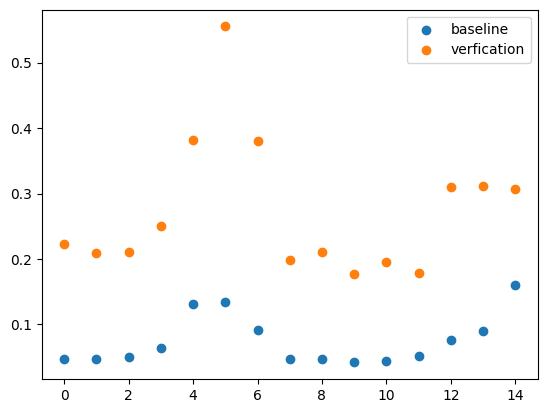

In [79]:
#very slow this block, how???
import pylab
Xs = np.arange(len(bases))
pylab.scatter(Xs, bases, label="baseline")
pylab.scatter(Xs, vers, label="verfication")
pylab.legend()